# Task

A house flipping company would like to identify underpriced homes by comparing asking prices to predicted sale prices.   They would like to segment homes into groups to analyze what kinds of homes there are. They would also like a model that predicts the selling price of a home.

The company has provided publicly available data from the King County Assessor's office to use for clustering and prediction.

Data notes:
BrickStone is the percentage of a house that is made of brick or stone.

###  imports and funtions

In [12]:
# all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#processing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, classification_report,mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
from tensorflow.keras.metrics import RootMeanSquaredError

In [13]:
# some custom funtions for evaluating models later on
def eval_regression(model, X, y, name='model'):
    score_df = pd.DataFrame(index=[name])
    preds = model.predict(X)
    score_df.loc[name,'MAE'] = mean_absolute_error(y, preds)
    score_df.loc[name,'RMSE'] = np.sqrt(mean_squared_error(y, preds))
    score_df.loc[name,'R2'] = r2_score(y, preds)
    return score_df

def plot_history(history):
  metrics = history.history.keys()
  for metric in metrics:
      if not 'val' in metric:
        plt.plot(history.history[f'{metric}'], label=f'{metric}')
        if f'val_{metric}' in metrics:
          plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.title(f'{metric}')
        plt.show()


# Part 1: Clustering instructions:
The house flipping company would like you to segment the homes sold in the database and create an analytical report on the clusters describing each cluster and describing how they are different. The data has had some cleaning work to it, but you should verify that it is ready for clustering.

- Load this dataset for clustering
- Explore the data and clean it as needed.
- Prepare the data for modeling
- Use a KMeans model to cluster the houses into an optimal number of clusters.
  - Use an elbow plot and silhouette score to find the optimal number of clusters.
  - There must be between 2 and 10 clusters.
  - Explain your choice of the number of clusters.
- Analyze and report on the clusters.
  - Create 2 report quality explanatory visualizations showing important differences between the clusters.
  - Interpret and explain each visualization.

In [14]:

df=pd.read_csv('Data\option_A_clustering_df - option_A_clustering_df.csv')

In [15]:
df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,220,0,6,0,2,1,1965,-122.196399,47.336118
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,340,0,4,1,0,1,1945,-122.361913,47.509874
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.156684,47.437557
3,659000,660,0,540,0,1820,620,620,0,0,...,0,100,0,3,1,0,2,2016,-122.370252,47.565146
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,320,0,3,0,0,2,1967,-122.184194,47.730389


In [16]:
#import DF

df=pd.read_csv('Data\option_A_clustering_df - option_A_clustering_df.csv')
df.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,220,0,6,0,2,1,1965,-122.196399,47.336118
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,340,0,4,1,0,1,1945,-122.361913,47.509874
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.156684,47.437557
3,659000,660,0,540,0,1820,620,620,0,0,...,0,100,0,3,1,0,2,2016,-122.370252,47.565146
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,320,0,3,0,0,2,1967,-122.184194,47.730389


In [17]:
df.shape

(4944, 22)

## Data Exploration

In [18]:
duplicates = df.duplicated().sum()
print(f"There are {duplicates} duplicate rows in this dataset.")

There are 29 duplicate rows in this dataset.


In [19]:
duplicated_rows = df.duplicated(keep=False)
duplicated_rows.sum()

53

In [20]:
df[duplicated_rows].sort_values('Latitude')
# sort by lattitude since there cant be two homes on same coordinate


,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
2740,645950,1025,0,1462,0,2487,0,0,0,400,...,0,0,0,4,0,1,2,2019,-122.157389,47.436197
1664,645950,1025,0,1462,0,2487,0,0,0,400,...,0,0,0,4,0,1,2,2019,-122.157389,47.436197
384,684950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.157389,47.436197
388,684950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.157389,47.436197
2495,657950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2018,-122.155241,47.437076
2431,657950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2018,-122.155241,47.437076
4089,642950,1025,0,1462,0,2487,0,0,0,400,...,0,0,0,4,0,1,2,2018,-122.156684,47.437557
1164,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.156684,47.437557
3560,642950,1025,0,1462,0,2487,0,0,0,400,...,0,0,0,4,0,1,2,2018,-122.156684,47.437557
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,4,1,0,2,2019,-122.156684,47.437557


In [21]:
# Remove duplicates
df = df.drop_duplicates()
df.duplicated().sum()

0

In [22]:
#Check impossible values
val_cols = df.select_dtypes("number").columns
val_cols

for col in val_cols:
  print(f"Value Counts for {col}")
  print(df[col].value_counts())
  # Increasing readability by adding an empty line
  print('\n')

Value Counts for SalePrice
700000     65
650000     55
750000     48
350000     46
550000     46
           ..
389995      1
1064000     1
474250      1
815800      1
1214950     1
Name: SalePrice, Length: 1676, dtype: int64


Value Counts for SqFt1stFloor
1010    69
1300    58
1100    57
1090    56
1200    55
        ..
2780     1
2460     1
1145     1
1771     1
1126     1
Name: SqFt1stFloor, Length: 304, dtype: int64


Value Counts for SqFtHalfFloor
0       4421
500       17
700       13
420       13
600       12
        ... 
840        1
1080       1
441        1
728        1
130        1
Name: SqFtHalfFloor, Length: 114, dtype: int64


Value Counts for SqFt2ndFloor
0       3105
430       40
480       37
530       35
570       35
        ... 
2107       1
2060       1
441        1
2090       1
1126       1
Name: SqFt2ndFloor, Length: 235, dtype: int64


Value Counts for SqFtUpperFloor
0       4646
520       15
430       15
530       14
450       13
500       13
390       11
440    

In [23]:
# check for null
df.isna().sum()

SalePrice             0
SqFt1stFloor          0
SqFtHalfFloor         0
SqFt2ndFloor          0
SqFtUpperFloor        0
SqFtTotLiving         0
SqFtTotBasement       0
SqFtFinBasement       0
SqFtGarageBasement    0
SqFtGarageAttached    0
DaylightBasement      0
SqFtOpenPorch         0
SqFtEnclosedPorch     0
SqFtDeck              0
BrickStone            0
Bedrooms              0
BathHalfCount         0
Bath3qtrCount         0
BathFullCount         0
YrBuilt               0
Longitude             0
Latitude              0
dtype: int64

In [24]:
# overall dtypes check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4915 entries, 0 to 4943
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SalePrice           4915 non-null   int64  
 1   SqFt1stFloor        4915 non-null   int64  
 2   SqFtHalfFloor       4915 non-null   int64  
 3   SqFt2ndFloor        4915 non-null   int64  
 4   SqFtUpperFloor      4915 non-null   int64  
 5   SqFtTotLiving       4915 non-null   int64  
 6   SqFtTotBasement     4915 non-null   int64  
 7   SqFtFinBasement     4915 non-null   int64  
 8   SqFtGarageBasement  4915 non-null   int64  
 9   SqFtGarageAttached  4915 non-null   int64  
 10  DaylightBasement    4915 non-null   int64  
 11  SqFtOpenPorch       4915 non-null   int64  
 12  SqFtEnclosedPorch   4915 non-null   int64  
 13  SqFtDeck            4915 non-null   int64  
 14  BrickStone          4915 non-null   int64  
 15  Bedrooms            4915 non-null   int64  
 16  BathHa

##model in kmeans to find optimal clusters

- Use an elbow plot and silhouette score to find the optimal number of clusters.
- There must be between 2 and 10 clusters.

In [25]:
# scale DF for modeling clusters
df_scaled = StandardScaler().fit_transform(df)

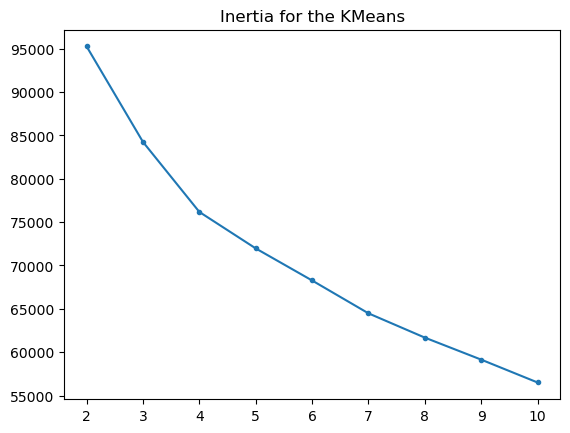

In [26]:
ks = range(2,11)
#Create an empty list of inertias
inertias = []
#Loop through k values between 2 and 10 and store the inertias in the list.
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)
#Visualize scores
plt.plot(ks, inertias,marker = '.')
plt.title('Inertia for the KMeans')
plt.show()

- inertia model  does not  give much of an elbow to judge, 4 is an elbow(ISH) try sihlouttee score to  narrow down selection.

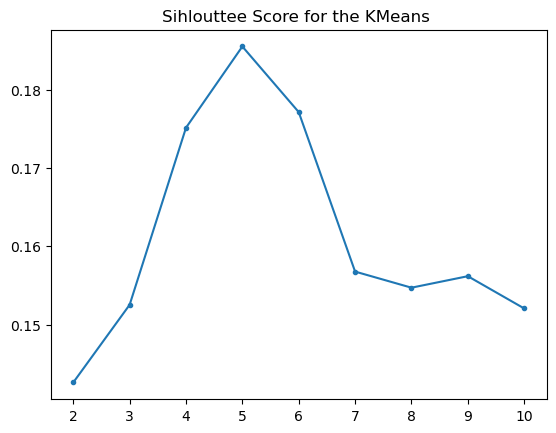

In [27]:
ks = range(2,11)
# Save silhouette scores for various cluster numbers in list
sil_score = []
#Loop through k values between 2 and 10 and store the sihlouttee scores in the list.
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_scaled)
    sil_score.append(silhouette_score(df_scaled, kmeans.labels_))
#Visualize scores
plt.plot(ks, sil_score,marker = '.')
plt.title('Sihlouttee Score for the KMeans ')
plt.show()

- Sihlouttee score
  - 6 is the highest sihlouttee score but paired with the inertia plot  there is not as drastic of an elbow.
  - 4 clusters  has a much more prevalant elbow in the inertia plot and  a still impressive sihlouttee score.
  
- 4 CLUSTERS have been chosen!



##Analyze Clusters

In [28]:
kmeans_final = KMeans(n_clusters = 4,random_state=42)
kmeans_final.fit(df_scaled)
# Add the clusters as a column in the dataframe
df['cluster'] = kmeans_final.labels_


In [29]:
# Group the dataframe by cluster and aggregate by mean values
# Add as_index=False to avoid setting as df index
clusters = df.groupby('cluster',as_index=False).mean()
clusters

,cluster,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,...,SqFtEnclosedPorch,SqFtDeck,BrickStone,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,YrBuilt,Longitude,Latitude
0,0,535441.334704,1198.650386,95.829306,64.987147,0.000000,1440.407712,361.093573,84.719794,28.699229,...,7.681234,66.243188,4.946015,3.019023,0.213882,0.283805,1.093059,1947.292545,-122.285139,47.557191
1,1,700563.034898,562.196149,6.309266,556.848375,148.950662,1537.246691,375.456077,266.551143,104.377858,...,16.281588,299.560770,0.481348,2.753309,0.529483,0.903730,1.245487,2015.955475,-122.332683,47.615999
2,2,716037.064815,1418.153846,29.830484,70.339031,0.000000,2334.504274,1248.960826,816.558405,238.179487,...,5.920940,203.675926,8.089031,3.804131,0.390313,0.945869,1.296296,1963.502849,-122.254255,47.581344
3,3,867099.687075,1368.091156,29.755102,1387.436735,8.965986,2946.763265,223.882993,154.715646,35.385034,...,5.034014,90.700680,0.619048,4.229932,0.682993,0.614966,2.051701,2003.353741,-122.199998,47.545655


### Visualize cluster Differences

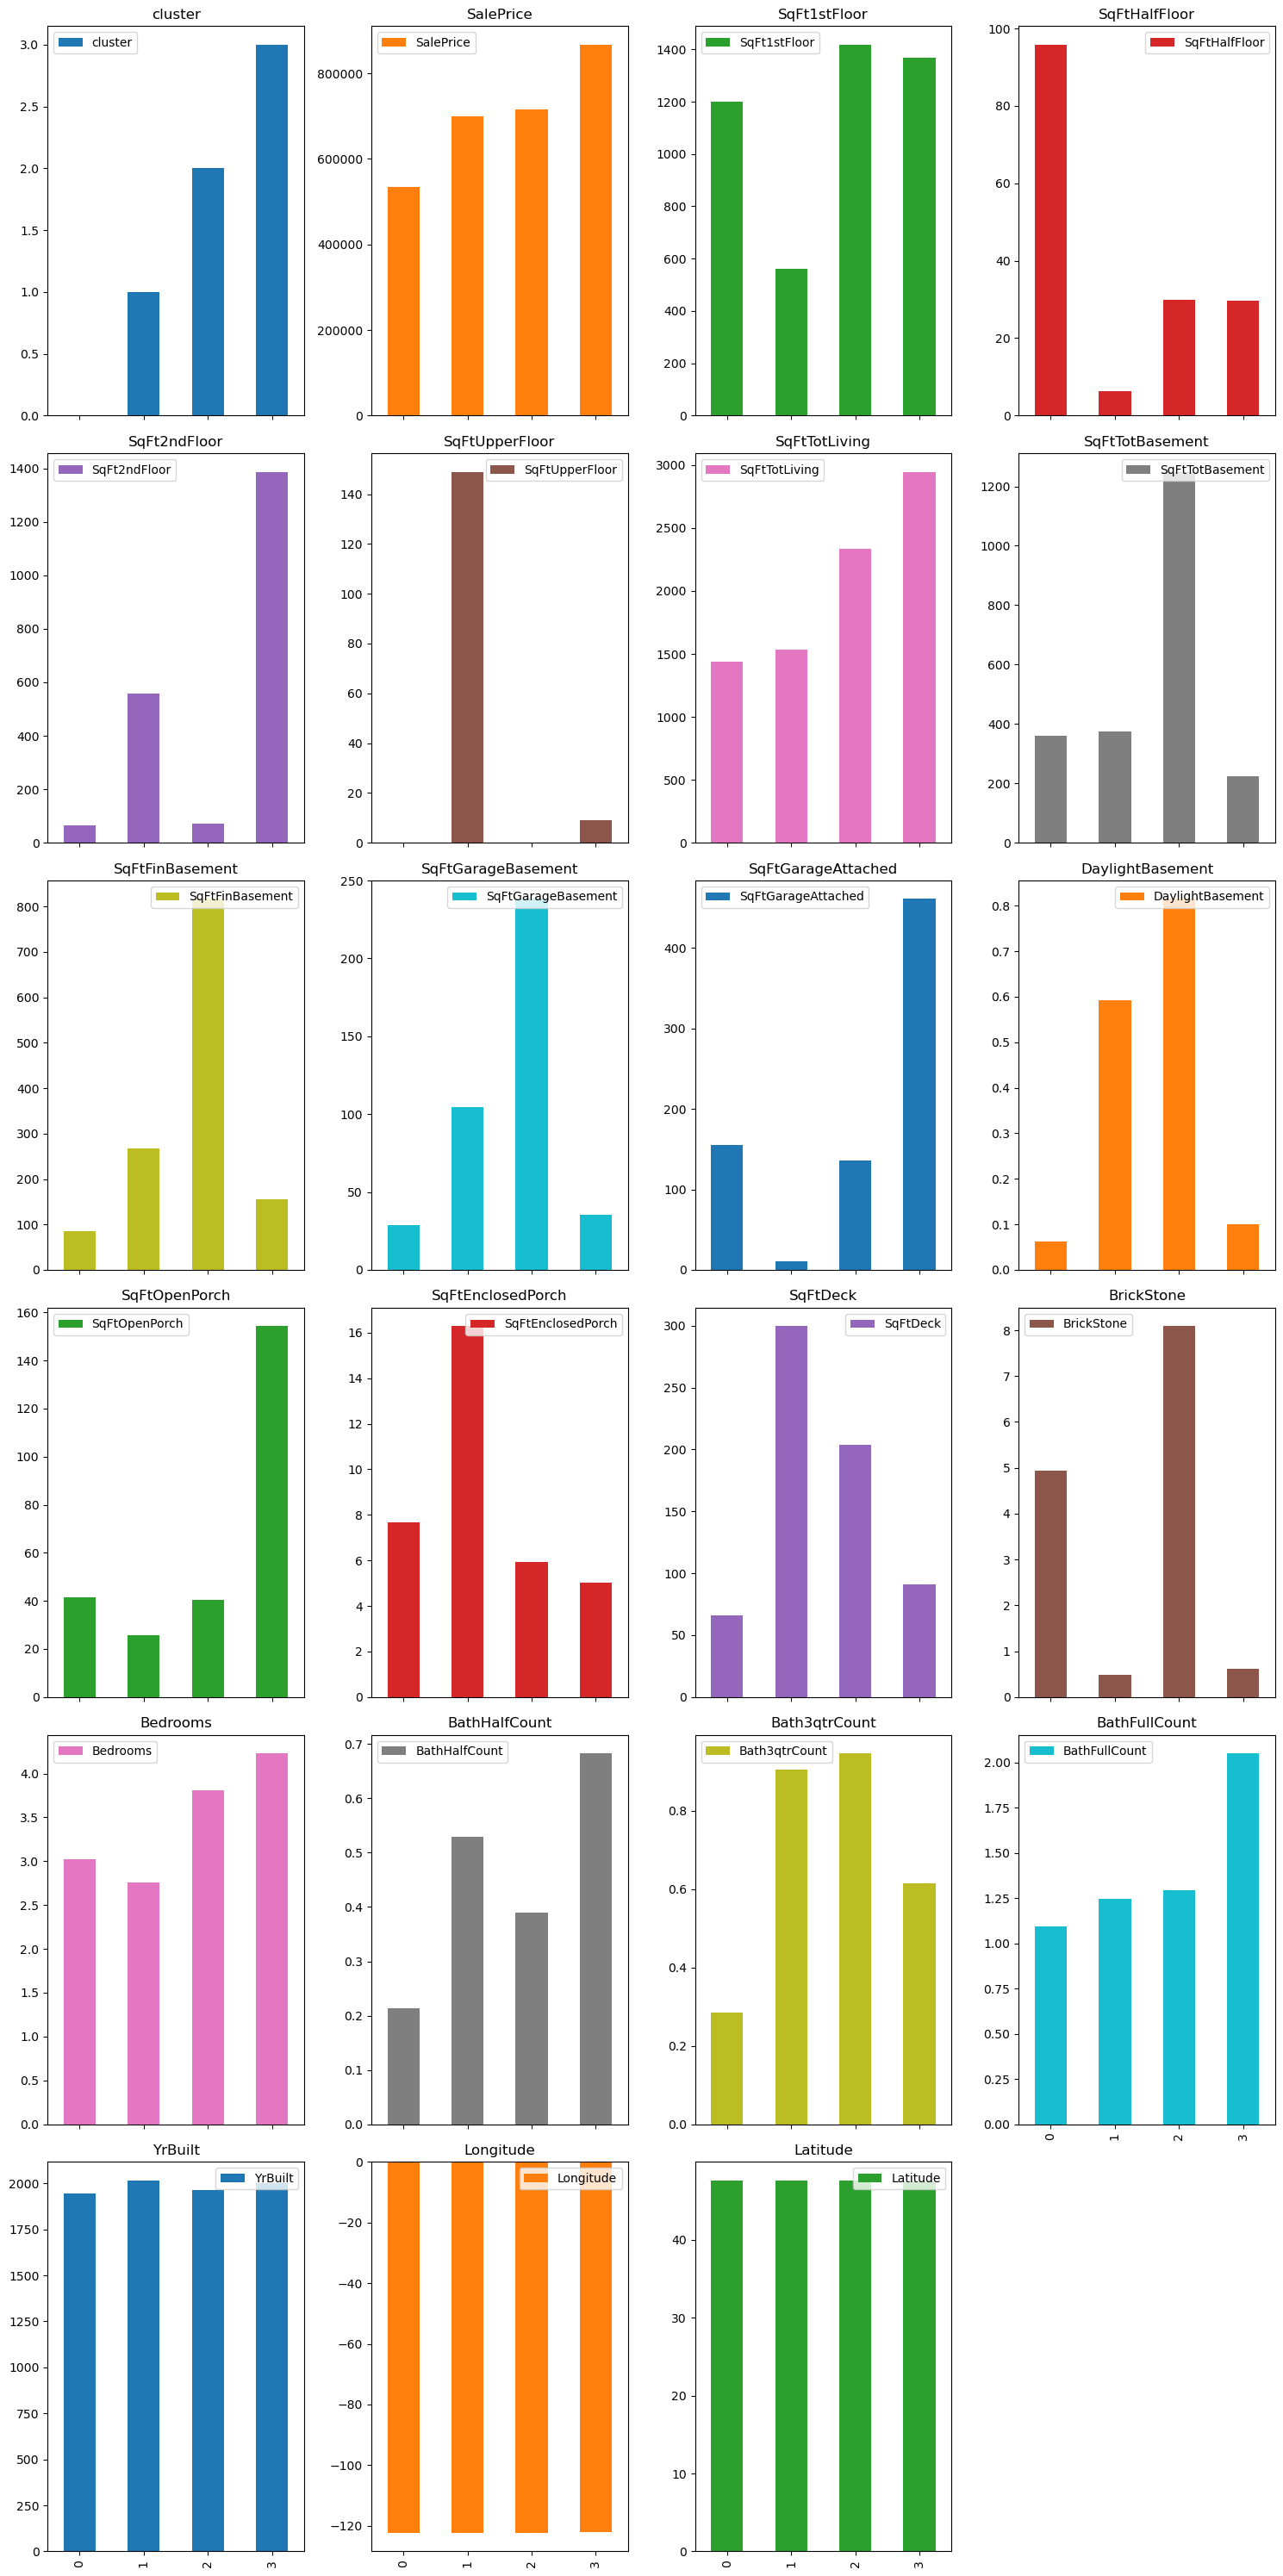

In [30]:
# plot the clusters
clusters.plot(subplots=True, kind='bar',
                     figsize=(15,30),
                     layout=(6,4))
plt.tight_layout()


### Home demographic overview
- Cluster0
  - large basements with daylight view
  - mostly brick/stone builds
  - large basaement garages
- Cluster1
  - most half floor sqft (loftstyle home)
  - smaller garagesor basement
  - lowest sqft livingsace
- Cluster2
  - large decks
  - largest top floor (stilthouses or townhomes)
  - larger  enclosed porches
- Cluster3
  - most multifloor floorplans
  - smaller basements
  - more baths
  - Highest listing prices

- overall summary
  - cluster0
    -  presents as  hillside homes with larger basement/garages that still have daylight views and made mostly of brick/stone
  - cluster1
    - more on the scale of a starter home with smaller floorplans, lower price and lack of multistory floorplans
  - cluster2
    - homes with larger outdoor living spaces such as townhomes with roof access
  - cluster3
    - larger homes with more sqft  and multiple floors, on average higher bed/
  bath count

  based on that rubric the following differences can be intrerpreted :

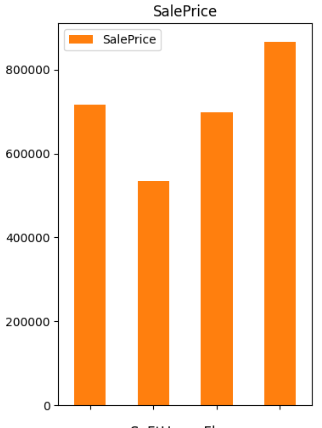






- according to the spread of price, cluster 2 falls in line with the  prediction of it being a less expensive starter home, clusters 0 and 2 can be interpreted as  mid range/ more extablished homes and cluster 3 is the larger more high end homes.


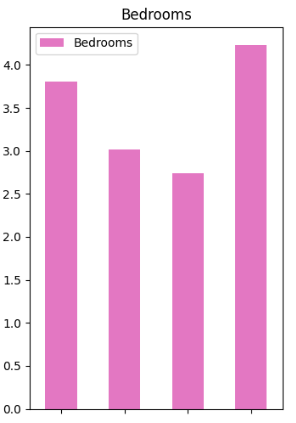

- according to the  amount of bedrooms generally observed in each cluster type it can be  interpreted that the cluster1 can be  an (average) amount of rooms for a starter home, cluster 0 is more rooms for a more established and larger home, cluster2 having less rooms which falls in line with it being a townhome type house, and finally cluster3 having the most amount of rooms  being on the larger side of the spectrum.

#Part 2: Modeling Instructions:
The house flipping company has provided new data about when the homes were sold and what businesses are nearby.  This new data has created a very large number of columns as the businesses, months sold, and years sold are all one-hot encoded.  

They would like you to use this new dataset to create a deep learning model that predicts the likely sale price for a new home coming to market.

Note: SalePrice is your target variable


- This dataset is pre-cleaned but may need to be processed before modeling.  
- Use random_state = 42 for your train_test_split
- Use PCA to prepare the data for modeling.
  - Reduce the number of features in the data
  - Be sure to use the PCA-transformed data when you fit and validate your deep learning model.
- Do not leak data while preparing your data for modeling.
- Use a deep learning model to predict the sale price of each house.
  - Use the PCA-transformed data you created in Step 4.
  - Create 3 different versions of a sequential model.
    - Each new model should be an iteration of the previous model.
    - Justify in writing why you changed what you did for each new model. (For example, why did you add layers, regularization, nodes, etc)
    - Adding or reducing epochs does not count as a new model.
  - Use some form of regularization with at least one model.
  - Evaluate each model with multiple appropriate metrics.
- Choose a final model and justify your choice.
- Evaluate your final model with multiple metrics.
- Based on those metrics, explain in writing how well your model will solve the business problem.

- SalePrice is the target variable so the metric to interpret will be regression

In [33]:
# load in DF
df2=pd.read_csv('Data\option_A_modeling_df - option_A_modeling_df.csv')
df2.head()

,SalePrice,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,SqFtGarageBasement,SqFtGarageAttached,...,MonthSold_07,MonthSold_08,MonthSold_09,MonthSold_10,MonthSold_11,MonthSold_12,YearSold_2017,YearSold_2018,YearSold_2019,YearSold_2020
0,400000,1590,0,0,0,3180,1590,1590,0,600,...,0,0,0,0,0,0,1,0,0,0
1,474250,1390,0,0,0,2200,810,810,0,0,...,0,0,0,0,0,0,0,1,0,0
2,667950,1010,0,1515,0,2525,0,0,0,400,...,0,0,0,0,0,0,0,0,1,0
3,659000,660,0,540,0,1820,620,620,0,0,...,0,0,1,0,0,0,1,0,0,0
4,656500,2310,0,0,0,2310,0,0,0,440,...,0,0,0,1,0,0,1,0,0,0


In [34]:
df2.shape

(4937, 171)

- DF has already been cleaned  so skipping the usual  isna/duplicates/valuecounts/unique  checks

In [35]:
# Separate the target and features.

X = df2.drop(columns='SalePrice')
y = df2['SalePrice']

# Train test split with randomstate from reproducability
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### PCA Scaling

In [36]:

# Create a scaler
scaler = MinMaxScaler()
# Create a PCA object that will retain 95% of the variance when transforming
pca = PCA(n_components = .99)
# Combine the scaler and the PCA in a pipeline.
pca_scaled = make_pipeline(scaler, pca)

train_PCA=pca_scaled.fit_transform(X_train)
test_PCA=pca_scaled.fit_transform(X_test)


# Transform the training data and check shape of new features after applying PCA
print('Shape before PCA:', X_train.shape,    X_test.shape)
print('Shape after PCA:',pca_scaled.fit_transform(X_train).shape,   pca_scaled.fit_transform(X_test).shape)
print('Column count reduced by: ', X_train.shape[1] - pca_scaled.fit_transform(X_train).shape[1])





Shape before PCA: (3702, 170) (1235, 170)
Shape after PCA: (3702, 144) (1235, 144)
Column count reduced by:  26


### deep learning model 1

In [37]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# use all features as input using input_dim
input_dim =train_PCA.shape[1]

# Instantiate your sequential model
model1 = Sequential()
# Add first hidden layer
model1.add(Dense(10, activation='relu', input_dim=input_dim, name='h1'))
# Add second hidden layer
model1.add(Dense(10, activation='relu', name='h2'))
# Add output layer with 1 node
model1.add(Dense(1, activation='linear', name ='output'))
# Check summary of network
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 10)                1450      
                                                                 
 h2 (Dense)                  (None, 10)                110       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0
_________________________________________________________________


In [38]:
# check input dip to ensure your fit correct  PCA scaled df
input_dim

144

In [39]:
# Compile your model.
model1.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])


In [40]:
# fit model

history = model1.fit(train_PCA, y_train,
                        validation_data = (test_PCA, y_test),
                        epochs=100,
                        verbose=0)


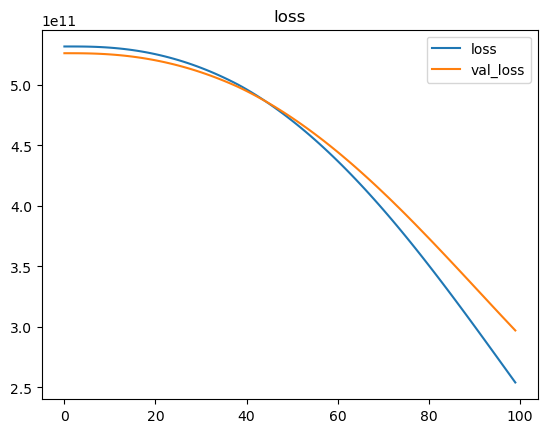

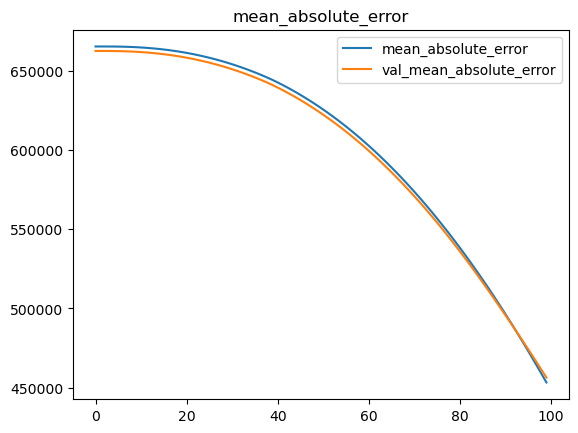

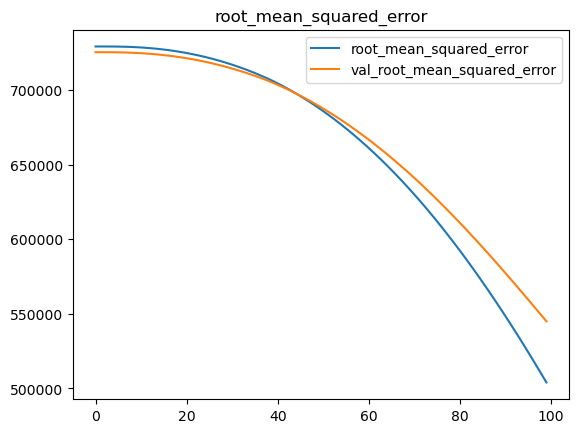

In [41]:
plot_history(history)

In [42]:
train_scores = eval_regression(model1,
                        train_PCA,
                         y_train,
                         name='model1 Train')
test_scores = eval_regression(model1,
                                       test_PCA,
                                       y_test,
                                       name='model1 Test')
scores = pd.concat([train_scores, test_scores])
scores

39/39 [==============================] - 0s 842us/step


,MAE,RMSE,R2
model1 Train,450750.607915,501377.062523,-1.817448
model1 Test,456466.006373,545014.149144,-2.398792


- model one  is showing signs of underfitting  and is too simple, to combat this  model 2 will increase complexity and increasethe training epochs

### deep learning model 2

- triple  the neurons in both hidden layers to add complexity and combat the underfiting of the first model

In [43]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# use all features as input using input_dim
input_dim =train_PCA.shape[1]

# Instantiate your sequential model
model2 = Sequential()
# Add first hidden layer
model2.add(Dense(30, activation='relu', input_dim=input_dim, name='h1'))
# Add second hidden layer
model2.add(Dense(30, activation='relu', name='h2'))
# Add output layer with 1 node
model2.add(Dense(1, activation='linear', name ='output'))
# Check summary of network
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 30)                4350      
                                                                 
 h2 (Dense)                  (None, 30)                930       
                                                                 
 output (Dense)              (None, 1)                 31        
                                                                 
Total params: 5,311
Trainable params: 5,311
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Compile your model.
model2.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])

In [45]:
# fit model

history = model2.fit(train_PCA, y_train,
                        validation_data = (test_PCA, y_test),
                        epochs=300,
                        verbose=0)


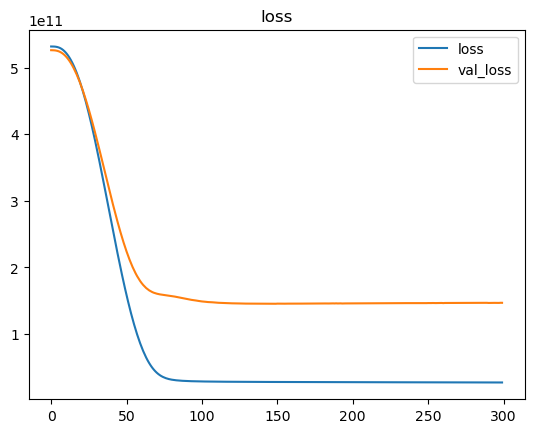

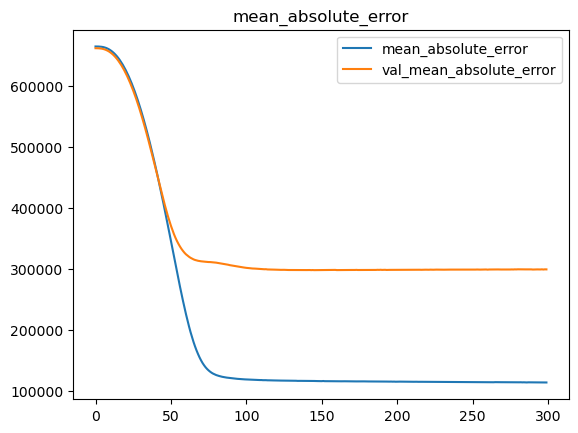

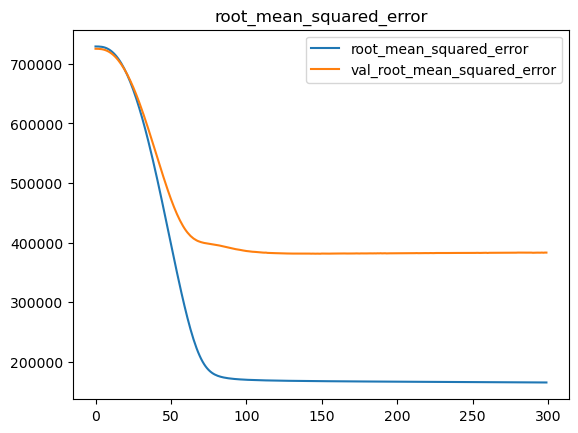

In [46]:
plot_history(history)

In [47]:
train_scores = eval_regression(model2,
                        train_PCA,
                         y_train,
                         name='model2 Train')
test_scores = eval_regression(model2,
                                       test_PCA,
                                       y_test,
                                       name='model2 Test')
scores = pd.concat([train_scores, test_scores])
scores

39/39 [==============================] - 0s 983us/step


,MAE,RMSE,R2
model2 Train,113951.424920,165334.856494,0.693623
model2 Test,299528.669484,383357.186930,-0.681575


- model2

  - the train and test have leveled out from the previous model  and model is no longer underfit, but model is now displaying Overfit qualities perfroming worse on test  data than on training data.
  - models seem to level out aorund 100 epochs, next model will decrease complexity abit and add regularization via  early stop  and dropout params since we can see visually where the model begins to stray from accuracy.

### Deep Learning model 3

 - decrease complexity
  
 - add earlystopping

- add dropout


In [48]:
# Reset Random seed for consistency
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)
# use all features as input using input_dim
input_dim =train_PCA.shape[1]
# Instantiate your sequential model
model3 = Sequential()
model3.add(Dense(25, activation='relu', input_dim=input_dim, name='h1'))
model3.add(Dropout(.8))
model3.add(Dense(30, activation='relu', name='h2'))
model3.add(Dense(30, activation='relu', name='h3'))


# Add output layer with 1 node
model3.add(Dense(1, activation='linear', name ='output'))
# Check summary of network
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 25)                3625      
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 h2 (Dense)                  (None, 30)                780       
                                                                 
 h3 (Dense)                  (None, 30)                930       
                                                                 
 output (Dense)              (None, 1)                 31        
                                                                 
Total params: 5,366
Trainable params: 5,366
Non-trainable params: 0
_________________________________________________________________


In [49]:
# Compile your model.


model3.compile(loss='mse',
                  optimizer='adam',
                  metrics=[metrics.MeanAbsoluteError(),
                           metrics.RootMeanSquaredError()])
early_stopping = EarlyStopping(patience = 4)


In [50]:
# fit model

history = model3.fit(train_PCA, y_train,
                        validation_data = (test_PCA, y_test),
                        epochs=200,
                        verbose=0,
                     callbacks = [early_stopping])

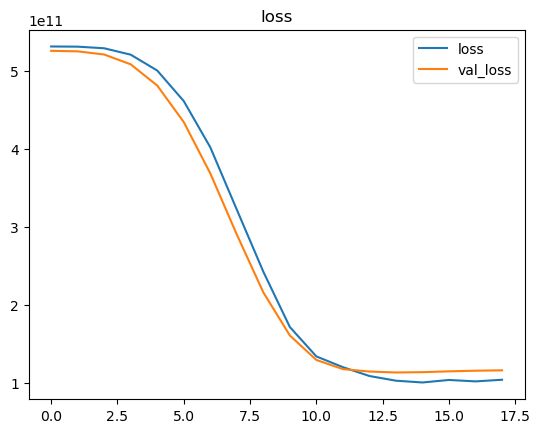

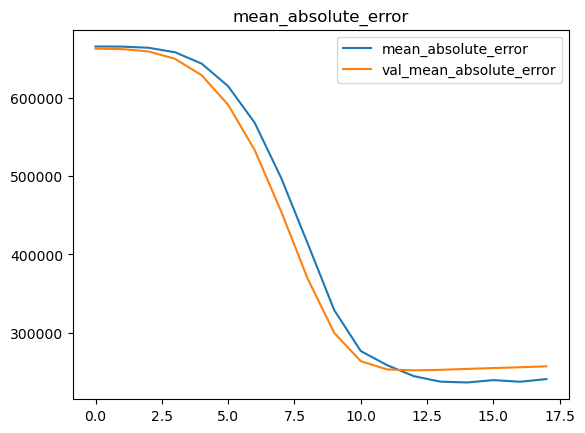

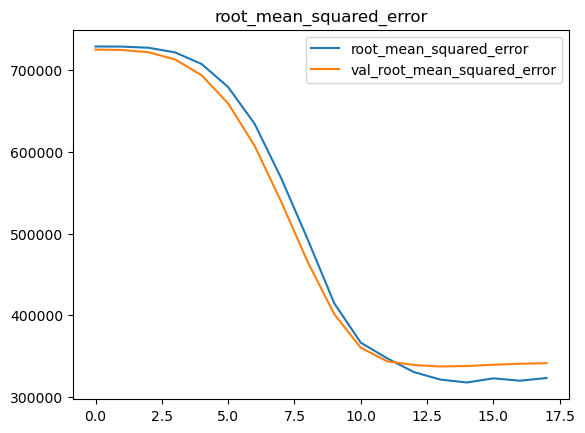

In [51]:
plot_history(history)

In [52]:
train_scores = eval_regression(model3,
                        train_PCA,
                         y_train,
                         name='model3 Train')
test_scores = eval_regression(model3,
                                       test_PCA,
                                       y_test,
                                       name='model3 Test')
scores = pd.concat([train_scores, test_scores])
scores

39/39 [==============================] - 0s 975us/step


,MAE,RMSE,R2
model3 Train,135176.549082,205348.104849,0.527384
model3 Test,257258.614942,341195.911854,-0.332038


- Model 3
  - model learning curve has leveled out.
  -  high variance has been managed.
  - model accuracy R2 scove has increased


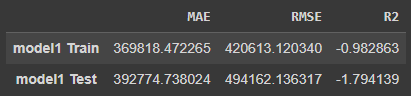

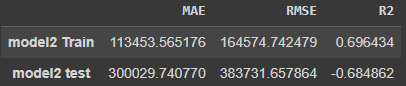

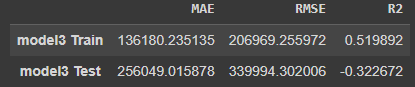

## model selection
the selected model will be model 3.
model 3 has been fine tuned to address the high variance than model1 and model 2 have and the model accuracy is far better as well.

## model 3

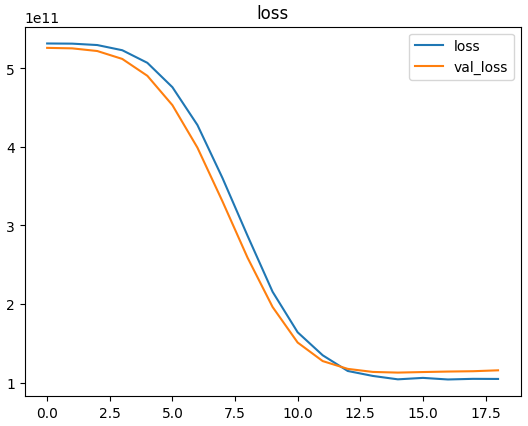


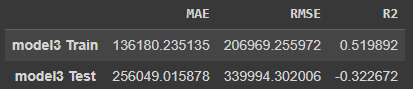

the learning model relates an efficient  level of variance and an acceptable level of accuracy to predict the home prices surrounding the included features.

Tableau Visualizations:

Interactive Visual for home price, bedrooms, SqFt and geographic area. created in Tableau.


[Seattle Home Values](https://public.tableau.com/app/profile/colin.lovestad/viz/Seattle_Housing_16980307174840/Dashboard1?publish=yes)
